Part of this notebook is taken from the tutorial-notebooks: 07b and 08 

In [1]:
email = "jsv1206@gmail.com"  
slugName = "sreevani/test-project-sj" 
%run Citizen_Science_SDK.ipynb

Installing external dependencies...
Done installing external dependencies!
Enter your Zooniverse credentials...


Username:  sreevani
 ········


You now are logged in to the Zooniverse platform.
Loaded Citizen Science SDK


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from lsst.rsp import get_tap_service, retrieve_query
import gc
import os

# Astropy
import astropy.units as u
from astropy.units import UnitsWarning
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [2]:
%matplotlib inline

In [3]:
#initializing Tap and Butler
pd.set_option('display.max_rows', 20)
warnings.simplefilter("ignore", category=UnitsWarning)
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [5]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

## Plotting functions

In [6]:
# Plot 
# def plotlc(days, magnitudes, band, out_name):
#     fig = plt.figure(figsize=(8,8))
#     plt.plot(days[band], magnitudes[band],
#              'k.', ms=10)
#     plt.minorticks_on()
#     plt.xlabel('MJD (days)')
#     plt.ylabel(band)
#     plt.savefig(out_name)
    
#     return fig
#     #plt.show() 
    
def plotlc(days, magnitudes, out_name):
    fig = plt.figure(figsize=(8,8))
    for band in bands:
        plt.plot(days[band], magnitudes[band],
                 plot_filter_symbols[band], ms=10, label=band)
    plt.minorticks_on()
    plt.xlabel('MJD (days)')
    plt.ylabel('magnitude')
    #plt.legend('upper right')
    plt.savefig(out_name)
    return fig
    #plt.show() 
    
def make_fig(cutout_image, ra, dec, out_name):
    """
    Create an image.
    should be followed with remove_figure

    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    out_name : file name where you'd like to save it
    
    """
    fig = plt.figure(figsize=(4, 4))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(cutout_image.image)
    
    cutout_wcs = cutout_image.getWcs()
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
    afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
    plt.gca().axis('off')
    plt.savefig(out_name)
    
    return fig
    
    
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call the garbage collector
    

## Creating directories to save lightcurves and coadds

In [7]:
plots = []
bands = ['g','r','i']
batch_dir = './variable_stars_output'

In [8]:
if os.path.isdir(batch_dir) == False:
    os.mkdir(batch_dir)
    
if os.path.isdir(batch_dir+'/lc_plots') == False:
    os.mkdir(batch_dir+'/lc_plots')
else:
    os.system('rm -r '+batch_dir+'/lc_plots/*')
    
if os.path.isdir(batch_dir+'/text_files') == False:
    os.mkdir(batch_dir+'/text_files')
else:
    os.system('rm -r '+batch_dir+'/text_files/*')
    
if os.path.isdir(batch_dir+'/coadd_images') == False:
    os.mkdir(batch_dir+'/coadd_images')
else:
    os.system('rm -r '+batch_dir+'/coadd_images/*')

rm: cannot remove ‘./variable_stars_output/coadd_images/*’: No such file or directory


## Query to get variable stars

Selecting stars (truth_type=2)

variable (is_variable = 1)

is_pointsource = 1

In [9]:
def query_stars(ra_deg, dec_deg, radius_deg, limit):
    #radius within which you want to query
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) <= 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

def query_one_star(ra_deg, dec_deg, radius_deg, limit):
    #radius within which you want to query
    
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) = 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

In [13]:
%%time
#Let's look at one RR-Lyrae
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

#if you want to query multiple stars within a radius
#variable_stars = query_one_star(ra_known_rrl, dec_known_rrl, 0.001,10)

#query one star
variable_stars = query_one_star(ra_known_rrl, dec_known_rrl, 0.001,10)

CPU times: user 8.14 ms, sys: 1.03 ms, total: 9.16 ms
Wall time: 1.21 s


In [14]:
variable_stars

,id_truth_type,match_objectId,ra,dec
0,835714_2,1651589610221899038,62.147903,-35.799138


## Query to get the flux at all the bands

In [15]:
def query_flux(objid):
    query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
            "src.objectId, src.psfFlux, src.psfFluxErr, "\
            "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
            "visinfo.band, "\
            "visinfo.expMidptMJD "\
            "FROM dp02_dc2_catalogs.ForcedSource as src "\
            "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
            "ON visinfo.ccdVisitId = src.ccdVisitId "\
            "WHERE src.objectId = "+str(objid)+" "
    lc = service.search(query)
    flux_allbands = lc.to_table()
    # Create masks for the bands
    pick = {}
    for filter in plot_filter_labels:
        pick[filter] = (flux_allbands['band'] == filter)
    mjd_days = {}
    mags = {}
    for filter in plot_filter_labels:
        mjd_days[filter] = np.array(flux_allbands[pick[filter]]['expMidptMJD']) * u.day
        mags[filter] = np.array(flux_allbands[pick[filter]]['psfMag'])
        
    return mjd_days, mags

## Query coadd images from Butler

In [13]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get('skyMap')
image_size = 100 #pixels

In [14]:
# From Melissa Graham's notebook and from Zooniverse testing
# https://github.com/rubin-dp0/cst-dev/blob/main/MLG_sandbox/DP02/citsci_sample_demo.ipynb

def get_cutout_image(ra_deg,dec_deg,band,datasetType='deepCoadd',cutoutSideLength=image_size):
    """
    get the tract and patch of a source. currently retrieves i band only. 

    Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    spherePoint = geom.SpherePoint(ra_deg*geom.degrees, dec_deg*geom.degrees)
    tract = skymap.findTract(spherePoint)
    patch = tract.findPatch(spherePoint)
    xy = geom.PointI(tract.getWcs().skyToPixel(spherePoint))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    
    my_tract = tract.getId()
    my_patch = tract.getSequentialPatchIndex(patch)
    
    parameters = {'bbox': bbox}
    dataId = {'band': band, 'tract': my_tract, 'patch': my_patch}
    cutout_image = butler.get(datasetType, dataId=dataId, parameters=parameters)
    return cutout_image

In [15]:
# for index, row in variable_stars[0:2].iterrows():
#     for band in bands:
#         deepCoadd= get_cutout_image(row['ra'],row['dec'],band,datasetType='calexp')
#         figout = make_fig(deepCoadd, row['ra'],row['dec'],batch_dir+"/coadd_images/"+str(row['id_truth_type'])+"_"+band+".png")
#         remove_figure(figout)

In [16]:
for index, row in variable_stars[0:5].iterrows():
    for band in bands:
        deepCoadd= get_cutout_image(row['ra'],row['dec'],band,datasetType='deepCoadd')
        figout = make_fig(deepCoadd, row['ra'],row['dec'],batch_dir+"/coadd_images/"+str(row['id_truth_type'])+"_"+band+".png")
        remove_figure(figout)

## Plotting images and text files of the light curves

## Plotting of lightcurves taking too long!

Normalize the magnitudes

Try to get rid of multiple loops

In [19]:
# for index, row in variable_stars[0:2].iterrows():
#     mjd_days, mags = query_flux(row['match_objectId'])
#     figout = plotlc(mjd_days, mags, batch_dir+"/lc_plots/"+"lc_"+str(row['match_objectId'])+".png")
#     remove_figure(figout) 

In [37]:
def plotlc_oneband(days, magnitudes, out_name):
    fig = plt.figure(figsize=(20,4))
    for band in ['g','r','i']:
        plt.plot(days[band], magnitudes[band],
                 plot_filter_symbols[band], ms=10, label=band)
    plt.minorticks_on()
    plt.xlabel('MJD (days)')
    plt.ylabel('magnitude')
    #plt.legend('upper right')
    plt.savefig(out_name)
    return fig

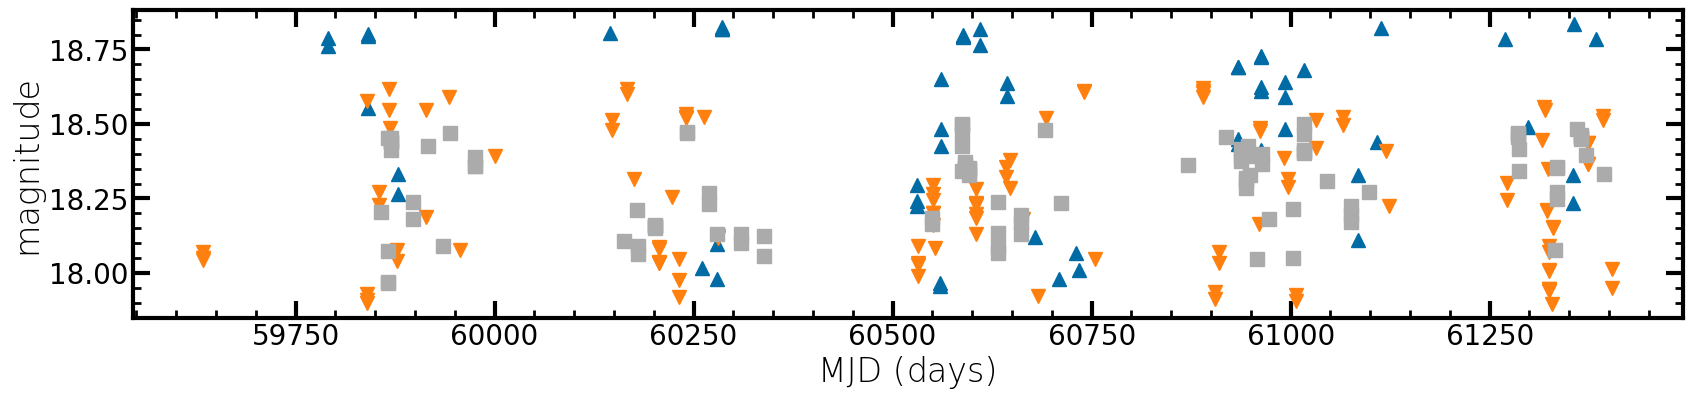

In [38]:
for index, row in variable_stars.iterrows():
    df_all_bands = []
    mjd_days, mags = query_flux(row['match_objectId'])
    plotlc_oneband(mjd_days, mags, batch_dir+"/lc_plots/"+"lc_"+str(row['match_objectId'])+".png")

In [39]:
%%time
for index, row in variable_stars.iterrows():
    df_all_bands = []
    mjd_days, mags = query_flux(row['match_objectId'])
    figout = plotlc(mjd_days, mags, batch_dir+"/lc_plots/"+"lc_"+str(row['match_objectId'])+".png")
    remove_figure(figout) 
    for band in bands:
        df = pd.DataFrame(data = {'band': [band]*len(mjd_days[band]), 'mjd_days': mjd_days[band], \
                          'mags': mags[band]}, index=None)
        df_all_bands.append(df)
    
    df_final = pd.concat(df_all_bands)
    outfile = batch_dir+"/text_files/"+"lc_"+str(row['match_objectId'])+".csv"
    df_final.to_csv(outfile, index=False, sep=',')

CPU times: user 518 ms, sys: 61.2 ms, total: 579 ms
Wall time: 742 ms


# Create csv for Zooniverse flipbook 

https://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifesthttps://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifest

In [21]:
df_row = []
for index, row in variable_stars[0:2].iterrows():
    df = pd.DataFrame(data = {'band_g': str(row['id_truth_type'])+"_g.png", 
                              'band_r': str(row['id_truth_type'])+"_r.png",
                              'band_i': str(row['id_truth_type'])+"_i.png"}, index=[0])
    df_row.append(df)
    
df_manifest = pd.concat(df_row)

outfile = batch_dir+"/flipbook_manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')

# Send data to Zooniverse

In [22]:
cutouts = []
fields_to_add = ["objectId", "coord_ra", "coord_dec", "detect_isPrimary", "g_cModelFlux", "r_cModelFlux", "r_extendedness", "r_inputCount"]

for index, row in variable_stars[0:5].iterrows():
    for band in bands:
        figout_data = {
        "filename": str(row['id_truth_type'])+"_"+band+".png",
        "edc_ver_id": 'xxx',    
        "objectId": row['id_truth_type']
        }
        
        if "coord_ra" in fields_to_add:
            figout_data["coord_ra"] = row['ra']
        if "coord_dec" in fields_to_add:
            figout_data["coord_dec"] = row['dec']
        if "g_cModelFlux" in fields_to_add:
            figout_data["g_cModelFlux"] = True
        if "r_cModelFlux" in fields_to_add:
            figout_data["r_cModelFlux"] = 26.5
        if "r_extendedness" in fields_to_add:
            figout_data["r_extendedness"] = 1.0
        if "r_inputCount" in fields_to_add:
            figout_data["r_inputCount"] = 1.0
        cutouts.append(figout_data)
        
cutout_dir = batch_dir+"/coadd_images/"

In [23]:
list(cutouts[0].keys())

['filename',
 'edc_ver_id',
 'objectId',
 'coord_ra',
 'coord_dec',
 'g_cModelFlux',
 'r_cModelFlux',
 'r_extendedness',
 'r_inputCount']

In [24]:
subject_set_name = "variable stars cutouts" 

In [25]:
__cit_sci_data_type = _HIPS_CUTOUTS # Important: DO NOT change this value. Update - this value may be changed.
send_data(subject_set_name, cutout_dir, cutouts)

'1. Checking batch status'

'2. Writing metadata file required by the Rubin EPO Data Center.'

'3. Zipping up all the astro cutouts - this can take a few minutes with large data sets, but unlikely more than 10 minutes.'

'4. Uploading the citizen science data'

'5. Creating a new Zooniverse subject set'

'6. Notifying the Rubin EPO Data Center of the new data, which will finish processing of the data and notify Zooniverse'

'7. Cleaning up unused subject set on the Zooniverse platform, vendor_batch_id : 112310'